### Validation and Analysis of Initial Model

In [3]:
from ultralytics import YOLO
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import shutil
import image_transformation_functions as transf_func

### Validate Model

In [9]:
# model trained for 100 epochs on expanded dataset
model = YOLO("C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/model_boxes_only.pt")

In [10]:
# validate model on validation set
metrics = model.val(data="C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/data.yaml")

Ultralytics YOLOv8.0.196  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 268 layers, 68132235 parameters, 0 gradients, 257.4 GFLOPs
val: Scanning C:\Users\jamie\Python Projects\Dissertation\Task\datasets\WSP-8\valid\labels.cache... 153 images, 1 backg
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [02:59
                   all        153        423       0.72      0.717      0.725      0.591
           Articulated        153         18      0.449      0.722      0.682      0.529
                   Bus        153         17      0.635      0.615      0.648      0.513
                   Car        153        144      0.761      0.806      0.848      0.582
                 Coach        153          6      0.829      0.167      0.225      0.225
                   LGV        153        122      0.788      0.852      0.875      0.677
          Rigid 2 Axle        153         6

In [13]:
# mean average precision all classes (mAP50)
round(metrics.box.map50,3)

0.725

#### mAP50 Priority Classes
- locate AP50 for LGV, Rigid 2 Axle, Rigid 3 Axle, Rigid 4 Axle
- sum AP50 together
- divide by number of classes (4)

In [52]:
# ap50 LGV, R2A, R3A, R4A
priority_classes = [metrics.box.ap50[4], metrics.box.ap50[5], metrics.box.ap50[6], metrics.box.ap50[7]]
priority_classes

[0.7807908105941884,
 0.7992456714833581,
 0.8064285714285717,
 0.8242353791155012]

In [56]:
# mAP50 priority classes
round(sum(priority_classes)/len(priority_classes),3)

0.803

#### mAP50 Lower-Priority Classes
- locate AP50 for cars, taxis, buses, coaches and articulated lorries
- sum AP50 together
- divide by number of classes (5)

In [60]:
# ap50 cars, taxis, buses, coaches, articulated
lower_priority_classes = [metrics.box.ap50[2], metrics.box.ap50[8], metrics.box.ap50[1], metrics.box.ap50[3], metrics.box.ap50[0]]
lower_priority_classes

[0.7113512740467437,
 0.46483870967741936,
 0.7167042113373383,
 0.246375,
 0.6063716208441338]

In [62]:
# mAP50 lower-priority classes
round(sum(lower_priority_classes)/len(lower_priority_classes),3)

0.549

#### Function for Calculating mAP50 for All Classes, Priority Classes and Lower-Priority Classes

In [3]:
# function for calculating mAP50 for all classes, priority classes and lower-priority classes
def calc_map50_class_groups(metrics_object):
    priority_classes = [metrics_object.box.ap50[4], metrics_object.box.ap50[5], metrics_object.box.ap50[6], metrics_object.box.ap50[7]]
    lower_priority_classes = [metrics_object.box.ap50[2], metrics_object.box.ap50[8], metrics_object.box.ap50[1], 
                              metrics_object.box.ap50[3], metrics_object.box.ap50[0]]
    priority_class_map50 = round(sum(priority_classes)/len(priority_classes),3)
    lower_priority_class_map50 = round(sum(lower_priority_classes)/len(lower_priority_classes),3)
    print(f"mAP50 for all classes is {round(metrics_object.box.map50,3)}")
    print(f"mAP50 for priority classes is {priority_class_map50}")
    print(f"mAP50 for lower-priority classes is {lower_priority_class_map50}")

In [20]:
# calculate mAP50 for all classes, priority classes and lower-priority classes
calc_map50_class_groups(metrics)

mAP50 for all classes is 0.725
mAP50 for priority classes is 0.913
mAP50 for lower-priority classes is 0.575


#### Visulising AP50 for Initial Model

C:\Users\jamie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


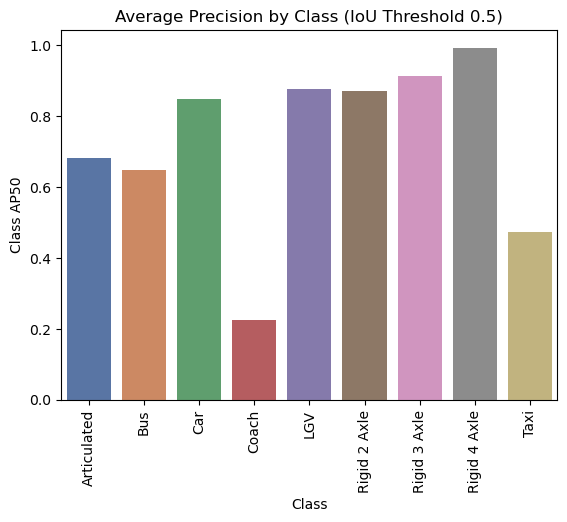

In [156]:
# barplot of AP50 for all classes
class_names = ['Articulated', 'Bus', 'Car', 'Coach', 'LGV', 'Rigid 2 Axle', 'Rigid 3 Axle', 'Rigid 4 Axle', 'Taxi']

ax = sns.barplot(x=class_names, y=metrics.box.ap50)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.xlabel("Class")
plt.ylabel("Class AP50")
plt.title("Average Precision by Class (IoU Threshold 0.5)")
plt.savefig("C:/Users/jamie/Python Projects/Dissertation/Task/EDA Code/Original WSP Dataset Charts/average_precision_by_class.png",bbox_inches="tight")
plt.show()

### Loss Function Graph

In [5]:
# DF for model
model_results = pd.read_csv("C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/results.csv")
model_results = model_results.rename(columns=lambda x: x.strip())

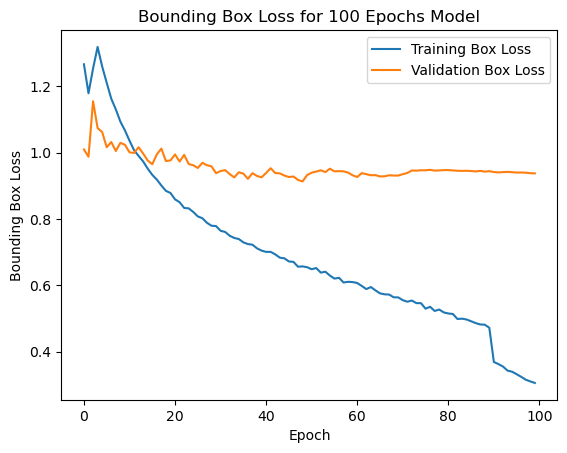

In [6]:
# loss graph for bounding boxes
plt.plot(model_results["epoch"], model_results["train/box_loss"], label="Training Box Loss")
plt.plot(model_results["epoch"], model_results["val/box_loss"], label="Validation Box Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Bounding Box Loss")
plt.title("Bounding Box Loss for 100 Epochs Model")
plt.savefig("C:/Users/jamie/Python Projects/Dissertation/Task/EDA Code/Validation charts/100_epoch_model_loss", bbox_inches="tight")
plt.show()

### Model Accuracy on Multi-Vehicle Images
- Split validation set into categories of images with multiple vehicles

In [66]:
# set validation labels directory
labels_directory = "C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/valid/labels/"

# save number of objects per image
class_labels_all_files = []
num_objects_per_file = []
for file in os.listdir(labels_directory):
    num_objects_per_file.append([file, len(transf_func.save_class_labels_from_file(f"{labels_directory}{file}"))])

# create df of number of objects per image
image_objects_df = pd.DataFrame(num_objects_per_file, columns=["file_name", "objects_per_file"])
image_objects_df

,file_name,objects_per_file
0,00001-07551_jpg.rf.42352026ee9c87fe3cf97107777...,6
1,05768-1718956992_jpg.rf.de0d03eea6445fee2efdae...,35
2,06498-1718956993_jpg.rf.081907f98a9dba1d09281d...,6
3,06498-1718969632_jpg.rf.29083e8f873ab791029101...,5
4,105_jpg.rf.90900220020f0ed93caf55096cacf05e.txt,2
...,...,...
148,videoframe_1655_png.rf.4a739d8cd67195a7f65ce76...,6
149,videoframe_1696_png.rf.a606af2d10891f60849da79...,3
150,videoframe_1780-1-_png.rf.7b80e7b5c82addc5d4ab...,10
151,videoframe_1924_png.rf.3420b5004d1dfb4e8ae50c0...,3


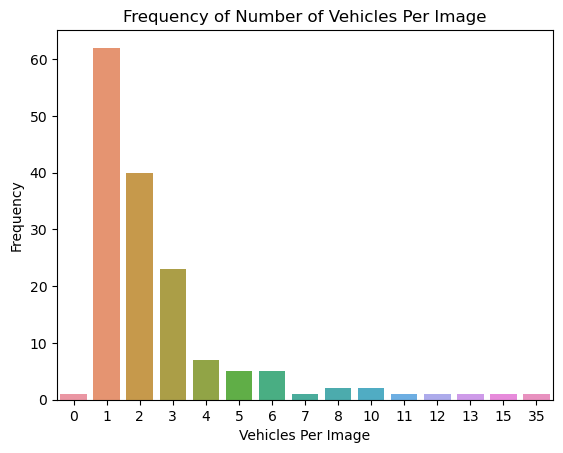

In [72]:
# bar plot number of objects per image
sns.set_palette("deep")
fig = sns.countplot(image_objects_df, x="objects_per_file")
fig.set_xlabel("Vehicles Per Image")
fig.set_ylabel("Frequency")
fig.set_title("Frequency of Number of Vehicles Per Image")
plt.savefig("C:/Users/jamie/Python Projects/Dissertation/Task/EDA Code/Original WSP Dataset Charts/frequency_number_vehicles_per_image.png", bbox_inches="tight")
plt.show()

Categories for number of vehicles per image:
- 0-3
- 4-10
- 11+

In [141]:
# set directory for copying multi-vehicle images
multi_vehicle_image_directory0 = "C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/valid/multi_vehicle_0_3/"
multi_vehicle_image_directory4 = "C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/valid/multi_vehicle_4_10/"
multi_vehicle_image_directory10 = "C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/valid/multi_vehicle_11/"
validation_image_directory = "C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/valid/images/"
validation_labels_directory = "C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/valid/labels/"

In [143]:
# copy files to separate directories for number of vehicles per image
# 0-3 vehicles per image
for file in image_objects_df[image_objects_df["objects_per_file"]<=3]["file_name"]:
    shutil.copyfile(f"{validation_image_directory}{file[:-4]}.jpg", f"{multi_vehicle_image_directory0}images/{file[:-4]}.jpg")
    shutil.copyfile(f"{validation_labels_directory}{file}", f"{multi_vehicle_image_directory0}labels/{file}")

# 4-10 vehicles per image
for file in image_objects_df[(image_objects_df["objects_per_file"]>3) & (image_objects_df["objects_per_file"]<=10)]["file_name"]:
    shutil.copyfile(f"{validation_image_directory}{file[:-4]}.jpg", f"{multi_vehicle_image_directory4}images/{file[:-4]}.jpg")
    shutil.copyfile(f"{validation_labels_directory}{file}", f"{multi_vehicle_image_directory4}labels/{file}")

# 11+ vehicles per image
for file in image_objects_df[image_objects_df["objects_per_file"]>10]["file_name"]:
    shutil.copyfile(f"{validation_image_directory}{file[:-4]}.jpg", f"{multi_vehicle_image_directory10}images/{file[:-4]}.jpg")
    shutil.copyfile(f"{validation_labels_directory}{file}", f"{multi_vehicle_image_directory10}labels/{file}")

"data.yaml" file has been edited to point to the relevant multi-vehicle image folder for validation

In [5]:
# model trained for 100 epochs on expanded dataset
model = YOLO("C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/model_boxes_only.pt")
# validate model on images with 0-3 vehicles
metrics_0_3_veh = model.val(data="C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/data_0_3_vehicles.yaml")

Ultralytics YOLOv8.2.78  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 268 layers, 68,132,235 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning C:\Users\jamie\Python Projects\Dissertation\Task\datasets\WSP-8\valid\multi_vehicle_0_3\labels.cache... 1
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [02:06<0


                   all        126        211      0.905       0.76      0.814      0.689
           Articulated          2          2      0.827        0.5      0.606      0.546
                   Car         36         41          1      0.799      0.956       0.74
                 Coach          3          4          1          0          0          0
                   LGV         74         82      0.975      0.963      0.974      0.802
          Rigid 2 Axle         39         42          1       0.86      0.992       0.87
          Rigid 3 Axle          2          2      0.923          1      0.995      0.902
          Rigid 4 Axle         36         37      0.972      0.956      0.992      0.858
                  Taxi          1          1       0.54          1      0.995      0.796
Speed: 3.4ms preprocess, 993.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val


In [7]:
# model trained for 100 epochs on expanded dataset
model = YOLO("C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/model_boxes_only.pt")
# validate model on images with 4-10 vehicles
metrics_4_10_veh = model.val(data="C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/data_4_10_vehicles.yaml")

Ultralytics YOLOv8.2.78  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 268 layers, 68,132,235 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning C:\Users\jamie\Python Projects\Dissertation\Task\datasets\WSP-8\valid\multi_vehicle_4_10\labels.cache... 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:26<0


                   all         22        126      0.655      0.632       0.74      0.613
           Articulated          4          9      0.535      0.667      0.708      0.549
                   Bus          7         16      0.714      0.625      0.655       0.51
                   Car         20         56      0.705      0.821      0.833       0.54
                 Coach          1          2      0.786        0.5      0.559      0.559
                   LGV         15         22       0.51      0.773      0.642      0.421
          Rigid 2 Axle         10         14      0.538        0.5      0.574      0.369
          Rigid 3 Axle          1          1          1          0      0.995      0.995
          Rigid 4 Axle          1          1      0.525          1      0.995      0.995
                  Taxi          5          5      0.581        0.8      0.701      0.576
Speed: 4.6ms preprocess, 1169.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\det

In [8]:
# model trained for 100 epochs on expanded dataset
model = YOLO("C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/model_boxes_only.pt")
# validate model on images with 11+ vehicles
metrics_11_veh = model.val(data="C:/Users/jamie/Python Projects/Dissertation/Task/datasets/WSP-8/data_11_vehicles.yaml")

Ultralytics YOLOv8.2.78  Python-3.11.7 torch-2.3.1+cpu CPU (AMD Ryzen 7 5800H with Radeon Graphics)
Model summary (fused): 268 layers, 68,132,235 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning C:\Users\jamie\Python Projects\Dissertation\Task\datasets\WSP-8\valid\multi_vehicle_11\labels.cache... 5 
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<0


                   all          5         86      0.708      0.581       0.63      0.477
           Articulated          3          7      0.628      0.857      0.698      0.537
                   Bus          1          1      0.731          1      0.995      0.895
                   Car          5         47      0.831      0.596      0.795      0.513
                   LGV          4         18          1      0.418       0.61      0.424
          Rigid 2 Axle          3          8      0.766      0.415      0.456      0.288
                  Taxi          3          5      0.291        0.2      0.226      0.204
Speed: 2.1ms preprocess, 1101.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs\detect\val3


C:\Users\jamie\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


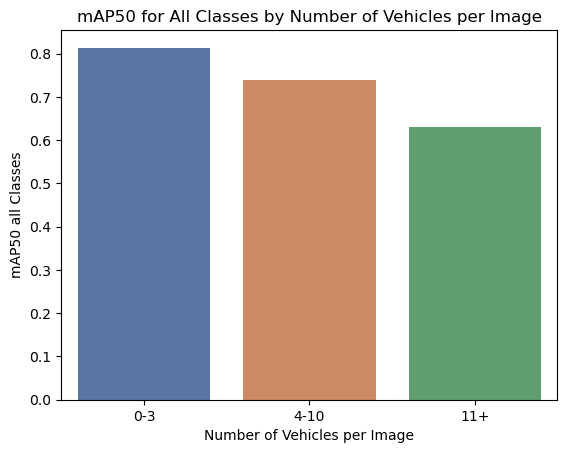

In [13]:
# barplot of mAP50 for all classes by number of vehicles per image
x = ["0-3", "4-10", "11+"]
y = [metrics_0_3_veh.box.map50, metrics_4_10_veh.box.map50, metrics_11_veh.box.map50]

sns.set_palette("deep")
ax = sns.barplot(x=x, y=y)
plt.xlabel("Number of Vehicles per Image")
plt.ylabel("mAP50 all Classes")
plt.title("mAP50 for All Classes by Number of Vehicles per Image")
plt.savefig("C:/Users/jamie/Python Projects/Dissertation/Task/EDA Code/Original WSP Dataset Charts/map50_by_num_vehicles_per_image.png",bbox_inches="tight")
plt.show()